In [1]:
import caffe
from caffe.proto import caffe_pb2
from caffe import layers as L, to_proto
from caffe import params as P
import numpy as np
import random
import os
import sys
import time
import tempfile
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) 

In [2]:
GPUId = 2 # can change this to 0,1,2
caffe.set_mode_gpu()
caffe.set_device(GPUId)

In [3]:
train_file_path = "data/development_kit/data/train.txt"
val_file_path = "data/development_kit/data/val.txt"
test_file_path = "data/development_kit/data/test.txt" 

print "Training File Contents..."
content = [line.rstrip() for line in open(train_file_path)]
random.shuffle(content)
for x in content[:10]:
    print x

Training File Contents...
train/a/aquarium/00000177.jpg 4
train/c/corn_field/00000145.jpg 40
train/a/abbey/00000250.jpg 0
train/b/boat_deck/00000159.jpg 19
train/m/market/outdoor/00000325.jpg 65
train/c/church/outdoor/00000677.jpg 32
train/b/banquet_hall/00000929.jpg 13
train/g/golf_course/00000724.jpg 51
train/s/shower/00000310.jpg 83
train/v/valley/00000550.jpg 97


In [4]:
#Data Parameters....
CROP_SIZE = 96
BATCH_SIZE = 128
TEST_BATCH_SIZE = 150
IMAGE_ROOT = "data/images/" #dont change this
BIAS_CONSTANT = 0
NET_PATH = "train-net.prototxt"
VAL_NET_PATH = "val-net.prototxt"
TEST_NET_PATH = "test-net.prototxt"
SOLVER_PATH = "solver.prototxt"

#Learning Parameters
weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]
conv_filler = dict(type='xavier')
const_filler = dict(type='constant', value=BIAS_CONSTANT)
fc_filler = dict(type='xavier')

In [5]:
test_file_names = [x.rstrip() for x in open(test_file_path).readlines()]
test_file_path = "data/development_kit/data/temp_test.txt"
f = open(test_file_path,'wb')
f.write(''.join('%s 0\n' % name for name in test_file_names))
f.close()

In [6]:
def get_data_layer(source,train=True,batch=BATCH_SIZE):
    mean = [104, 117, 123]  # per-channel mean of the BGR image pixels
    transform_param = dict(mirror=train, crop_size=CROP_SIZE, mean_value=mean)
    places_data, places_labels = L.ImageData(transform_param=transform_param,
                                             source=source,
                                             root_folder=IMAGE_ROOT,
                                             shuffle=train,
                                             batch_size=batch,
                                             ntop=2)
    return places_data,places_labels

train_data,train_labels = get_data_layer(train_file_path,True)
val_data,val_labels = get_data_layer(val_file_path,False,batch=TEST_BATCH_SIZE)
test_data,test_labels = get_data_layer(test_file_path,False,batch=TEST_BATCH_SIZE) # added this

In [7]:
def conv_relu(bottom, ks, nout, stride=1, pad=1, group=1,weight_filler=conv_filler, bias_filler=const_filler):
    conv = L.Convolution(bottom,
                         kernel_size=ks,
                         num_output=nout,
                         stride=stride,
                         pad=pad,
                         group=group,
                         param=learned_param,
                         weight_filler=weight_filler,
                         bias_filler=bias_filler)
    bn = L.BatchNorm(conv,param=[dict(lr_mult=0)] * 3)
    relu = L.ReLU(bn, in_place=True)
    return conv, relu

In [8]:
def fc_relu(bottom, nout,weight_filler=fc_filler, bias_filler=const_filler):
    fc = L.InnerProduct(bottom,
                        num_output=nout,
                        param=learned_param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    bn = L.BatchNorm(fc,param=[dict(lr_mult=0)] * 3)
    relu = L.ReLU(bn, in_place=True)
    return fc, relu

In [9]:
def max_pool(bottom, ks, stride=1, train=False):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

In [10]:
def places_net(source, net_path, has_labels=True, train=False,num_classes=100): # changed to add has_labels
    data = source['data']
    if has_labels:
        labels = source['labels']
    n = caffe.NetSpec()
    n.data = data
    
    n.conv1_1, n.relu1_1 = conv_relu(n.data, 3, 32, stride=1)
    n.conv1_2, n.relu1_2 = conv_relu(n.relu1_1, 3, 32, stride=1)
    n.pool1 = max_pool(n.relu1_2, 2, stride=2)
    
    n.conv2_1, n.relu2_1 = conv_relu(n.pool1, 3, 64, stride=1)
    n.conv2_2, n.relu2_2 = conv_relu(n.relu2_1, 3, 64, stride=1)
    n.pool2 = max_pool(n.relu2_2, 2, stride=2)
    
    n.conv3_1, n.relu3_1 = conv_relu(n.pool2, 3, 128, stride=1)
    n.conv3_2, n.relu3_2 = conv_relu(n.relu3_1, 3, 128, stride=1)
    n.conv3_3, n.relu3_3 = conv_relu(n.relu3_2, 3, 128, stride=1)
    n.pool3 = max_pool(n.relu3_3, 2, stride=2)
    
    n.conv4_1, n.relu4_1 = conv_relu(n.pool3, 3, 256, stride=1)
    n.conv4_2, n.relu4_2 = conv_relu(n.relu4_1, 3, 256, stride=1)
    n.conv4_3, n.relu4_3 = conv_relu(n.relu4_2, 3, 256, stride=1)
    n.pool4 = max_pool(n.relu4_3, 2, stride=2)

    n.fc5, n.relu5 = fc_relu(n.pool4, 4096)
    n.drop5 = L.Dropout(n.relu5, in_place=True)
    
    n.fc6, n.relu6 = fc_relu(n.drop5, 1024)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    
    layer_param = [dict(lr_mult=5, decay_mult=1), dict(lr_mult=10, decay_mult=0)]
    preds = n.fc7 = L.InnerProduct(n.drop6, num_output=num_classes,param=learned_param)
    
    if not train:
        # Compute the per-label probabilities at test/inference time.
        preds = n.probs = L.Softmax(n.fc7)
    if has_labels:   
        n.label = labels
        n.loss = L.SoftmaxWithLoss(n.fc7, n.label)
        n.accuracy_at_1 = L.Accuracy(preds, n.label)
        n.accuracy_at_5 = L.Accuracy(preds, n.label,accuracy_param=dict(top_k=5))
    with open(net_path,'w') as f:
        f.write(str(n.to_proto()))
    return net_path

In [12]:
train_net_file = places_net({'data': train_data, 'labels': train_labels}, NET_PATH, train=True)
val_net_file = places_net({'data': val_data, 'labels': val_labels}, VAL_NET_PATH, train=False)
test_net_file = places_net({'data': test_data, 'labels': test_labels},TEST_NET_PATH,has_labels=False,train=False)

In [11]:
def places_solver(snap_prefix):
    s = caffe_pb2.SolverParameter()
    s.train_net = train_net_file
    s.test_net.append(val_net_file)
    
    s.test_interval = 1000
    s.test_iter.append(67)
    s.iter_size = 2

    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # The following settings (base_lr, lr_policy, gamma, stepsize, and max_iter),
    # define the following learning rate schedule:
    #   Iterations [  0, 20K) -> learning rate 0.01   = base_lr
    #   Iterations [20K, 40K) -> learning rate 0.001  = base_lr * gamma
    #   Iterations [40K, 50K) -> learning rate 0.0001 = base_lr * gamma^2
    s.base_lr = 0.01
    s.lr_policy = 'step'
    s.gamma =  0.1
    s.stepsize = 15000
    s.max_iter = 150000

    # Set other SGD hyperparameters. 
    #`momentum` = takes a weighted average of the current gradient and previous gradients -> more stable learning
    # weight decay = regularizes learning; prevents overfitting
    s.momentum = 0.9
    s.weight_decay = 0.0005

    # Display the current training loss and accuracy every `display` iterations.
    s.display = 100
    s.average_loss = 10
    # Seed the RNG for deterministic results.
    s.random_seed = 1

    # Snapshots are files used to store networks we've trained
    s.snapshot = 5000
    s.snapshot_prefix = snap_prefix
    if not os.path.exists(s.snapshot_prefix):
        os.makedirs(s.snapshot_prefix)
    with open(SOLVER_PATH,'w') as f:
        f.write(str(s))
    return SOLVER_PATH  

In [13]:
solver_file = places_solver("snapshot/")
solver = caffe.get_solver(solver_file) 
#solver.restore("snapshot/_iter_49500.solverstate")

In [14]:
def eval_net(split_file_path,split_net,weight_file,split):
    K=5
    print 'Running evaluation for split:', split
    filenames = []
    labels = []
    split_file = split_file_path
    with open(split_file, 'r') as f:
        for line in f.readlines():
            parts = line.split()
            assert 1 <= len(parts) <= 2, 'malformed line'
            filenames.append(parts[0])
            if len(parts) > 1:
                labels.append(int(parts[1]))
    if split == "test":
        known_labels = False
    else:
        known_labels = (len(labels) > 0)
    if known_labels:
        assert len(labels) == len(filenames)
    test_net_file = split_net
    weights_file = weight_file
    net = caffe.Net(test_net_file, weights_file, caffe.TEST)
    top_k_predictions = np.zeros((len(filenames), K), dtype=np.int32)
    if known_labels:
        correct_label_probs = np.zeros(len(filenames))
    offset = 0
    while offset < len(filenames):
        net.forward()
        probs = net.blobs['probs'].data
        #probs = net.forward()['probs']
        for prob in probs:
            top_k_predictions[offset] = (-prob).argsort()[:K]
            if known_labels:
                correct_label_probs[offset] = prob[labels[offset]]
            offset += 1
            if offset >= len(filenames):
                break
    if known_labels:
        def accuracy_at_k(preds, labels, k):
            assert len(preds) == len(labels)
            num_correct = sum(l in p[:k] for p, l in zip(preds, labels))
            return num_correct*1.0 / len(preds)
        for k in [1, K]:
            accuracy = 100 * accuracy_at_k(top_k_predictions, labels, k)
            print '\tAccuracy at %d = %4.2f%%' % (k, accuracy)
        cross_ent_error = -np.log(correct_label_probs).mean()
        print '\tSoftmax cross-entropy error = %.4f' % (cross_ent_error, )
    else:
        print 'Not computing accuracy; ground truth unknown for split:', split
    filename = 'top_%d_predictions.%s.csv' % (K, split)
    with open(filename, 'w') as f:
        f.write(','.join(['image'] + ['label%d' % i for i in range(1, K+1)]))
        f.write('\n')
        f.write(''.join('%s,%s\n' % (image, ','.join(str(p) for p in preds))
                        for image, preds in zip(filenames, top_k_predictions)))
    print 'Predictions for split %s dumped to: %s' % (split, filename)

In [15]:
def train_net(iters,disp):
    outputs = sorted(solver.net.outputs)
    def str_output(output):
        value = solver.net.blobs[output].data
        if output.startswith('accuracy'):
            valstr = '%5.2f%%' % (100 * value, )
        else:
            valstr = '%6f' % value
        return '%s = %s' % (output, valstr)
    def disp_outputs(iteration, iter_pad_len=len(str(iters))):
        metrics = '; '.join(str_output(o) for o in outputs)
        return 'Iteration %*d: %s' % (iter_pad_len, iteration, metrics)
    # We could just call `solver.solve()` rather than `step()`ing in a loop.
    # (If we hadn't set GLOG_minloglevel = 3 at the top of this file, Caffe
    # would display loss/accuracy information during training.)
    previous_time = None
    for iteration in xrange(iters):
        solver.step(1)
        if (disp > 0) and (iteration % disp == 0):
            current_time = time.clock()
            if previous_time is None:
                benchmark = ''
            else:
                time_per_iter = (current_time - previous_time) / disp
                benchmark = ' (%5f s/it)' % time_per_iter
            previous_time = current_time
            print disp_outputs(iteration), benchmark
    # Print accuracy for last iteration.
    solver.net.forward()
    disp_outputs(iters)
    #solver.net.save(snapshot_at_iteration(args.iters))

In [ ]:
eval_net(val_file_path,val_net_file,"snapshot/_iter_49500.caffemodel",'validation')

In [ ]:
def extract_highlevel_rep(split_file_path,split_net,weight_file):
    FC6_DIM=1024
    print 'Extracting High Level Representations'
    filenames = []
    labels = []
    split_file = split_file_path
    with open(split_file, 'r') as f:
        for line in f.readlines():
            parts = line.split()
            assert 1 <= len(parts) <= 2, 'malformed line'
            filenames.append(parts[0])
            if len(parts) > 1:
                labels.append(int(parts[1]))
    known_labels = (len(labels) > 0)
    if known_labels:
        assert len(labels) == len(filenames)
    else:
        # create file with 'dummy' labels (all 0s)
        split_file = to_tempfile(''.join('%s 0\n' % name for name in filenames))
    test_net_file = split_net
    weights_file = weight_file
    net = caffe.Net(test_net_file, weights_file, caffe.TEST)
    high_level_reps = np.zeros((len(filenames), FC6_DIM), dtype=np.int32)

    offset = 0
    while offset < len(filenames):
        net.forward()
        dim_rep = net.blobs['fc6'].data
        high_level_reps[offset] = dim_rep
    with open(filename, 'w') as f:
        f.write(','.join(['dim'] + ['%d' % i for i in range(1, K+1)]))
        f.write('\n')
        f.write(''.join('%s\n' % (','.join(str(p) for p in preds))
                        for preds in high_level_reps))
    print 'High-level rep for %s dumped to: %s' % (split, filename)

In [ ]:
def eval_net_ensemble(split_file_path,nets, weights, split):
    K=5
    print 'Running evaluation for split:', split
    filenames = []
    labels = []
    split_file = split_file_path
    with open(split_file, 'r') as f:
        for line in f.readlines():
            parts = line.split()
            assert 1 <= len(parts) <= 2, 'malformed line'
            filenames.append(parts[0])
            if len(parts) > 1:
                labels.append(int(parts[1]))
    if split == "test":
        known_labels = False
    else:
        known_labels = (len(labels) > 0)
    if known_labels:
        assert len(labels) == len(filenames)
        
    net1 = caffe.Net(net1, weight1, caffe.TEST)
    net2 = caffe.Net(net2, weight2, caffe.TEST)
    
    top_k_predictions = np.zeros((len(filenames), K), dtype=np.int32)
    if known_labels:
        correct_label_probs = np.zeros(len(filenames))
    offset = 0

    while offset < len(filenames):
        for net in nets:
            net.foward()
        
        probs = np.zeros(1, len(labels))
        for net in nets:
            prob1 = net.blobs['probs'].data
            probs = np.maximum(prob1, probs)

        for prob in probs:
            top_k_predictions[offset] = (-prob).argsort()[:K]
            if known_labels:
                correct_label_probs[offset] = prob[labels[offset]]
            offset += 1
            if offset >= len(filenames):
                break
    if known_labels:
        def accuracy_at_k(preds, labels, k):
            assert len(preds) == len(labels)
            num_correct = sum(l in p[:k] for p, l in zip(preds, labels))
            return num_correct*1.0 / len(preds)
        for k in [1, K]:
            accuracy = 100 * accuracy_at_k(top_k_predictions, labels, k)
            print '\tAccuracy at %d = %4.2f%%' % (k, accuracy)
        cross_ent_error = -np.log(correct_label_probs).mean()
        print '\tSoftmax cross-entropy error = %.4f' % (cross_ent_error, )
    else:
        print 'Not computing accuracy; ground truth unknown for split:', split
    filename = 'top_%d_predictions.%s.csv' % (K, split)
    with open(filename, 'w') as f:
        f.write(','.join(['image'] + ['label%d' % i for i in range(1, K+1)]))
        f.write('\n')
        f.write(''.join('%s,%s\n' % (image, ','.join(str(p) for p in preds))
                        for image, preds in zip(filenames, top_k_predictions)))
    print 'Predictions for split %s dumped to: %s' % (split, filename)

In [ ]:
nets = ["test-net.prototxt", "val-net-vash.prototxt", "val-net-small.prototxt"]
weights = ["snapshot/_iter_49500.caffemodel", "snapshot_vash/_iter_25000.caffemodel", "snapshot_small/_iter_20000.caffemodel"]
eval_net_ensemble(val_file_path, nets, weights, "validation")

In [15]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')
    

# the parameters are a list of [weights, biases]

In [141]:
net = caffe.Net("val-net-vash.prototxt", "snapshot_vash/_iter_25000.caffemodel", caffe.TEST)
net.forward();

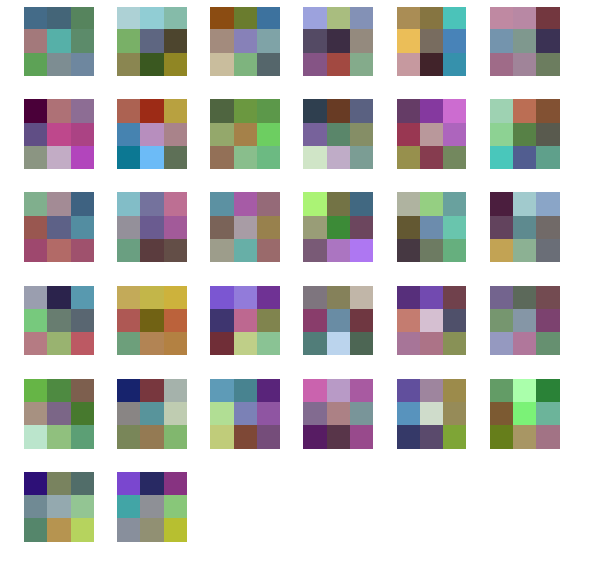

In [142]:
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

In [143]:
filters = net.params['[conv3_1]'][0].data
vis_square(filters)

KeyError: '[conv3_1]'

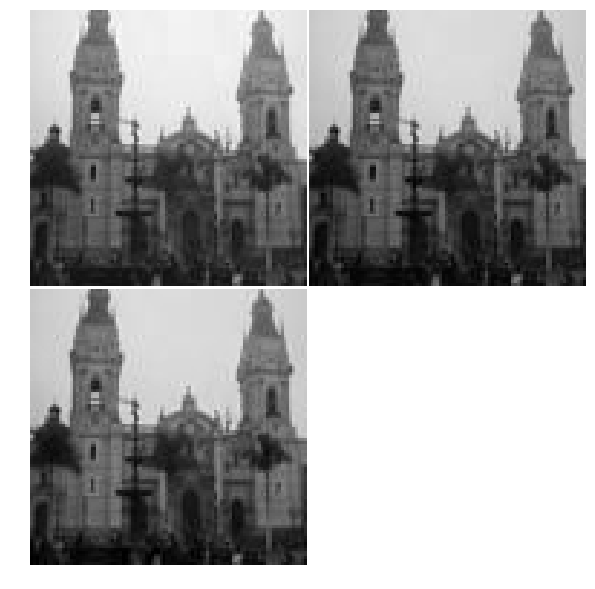

In [144]:
feat = net.blobs['data'].data[0]
vis_square(feat)

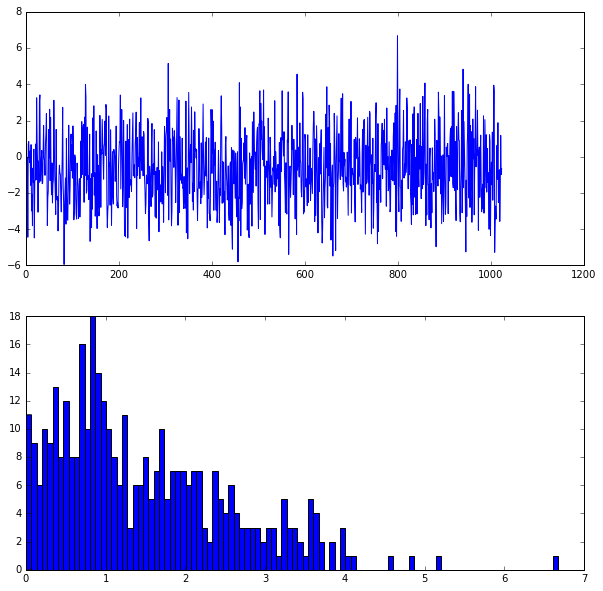

In [145]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

In [147]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)
print np.amax(feat.flat)

KeyError: 'prob'

In [149]:
eval_net("val-net-vash.prototxt",val_net_file,"snapshot_vash/_iter_5000.caffemodel","validation")

Running evaluation for split: validation


ValueError: invalid literal for int() with base 10: '{'